In [68]:
import pandas as pd
import re
import seaborn as sns

In [69]:
# load model eggnog tag and scores
model = pd.read_csv('CRC_OGs_adenoma_explanations.tsv', sep='\t')
model.columns = ['OG+', 'score', 'r_coeff', 'r_sing', 'r_pvalue', 'r_pvalue_fdr']
model = model.loc[model['score'] > 0]
model[['OG', 'TaxonomicLevel']] = model['OG+'].str.split('@', expand=True)
model.drop('OG+', axis=1, inplace=True)

# load eggnod 4.5 annotations
ann = pd.read_csv('all_OG_annotations.tsv', sep='\t', header=None)
ann.columns = ['OG', 'TaxonomicLevel', 'ProteinCount', 'Description', 'COGFunctionalCategory', 'GO', 'kegg_pathways', 'Domains', 'ProteinIDs']
ann = ann.loc[ann['OG'].isin(model['OG'])]
ann['COGFunctionalCategory'] = ann['COGFunctionalCategory'].apply(lambda x: x[3])

# merge model and annots
model = model.merge(ann[['OG', 'ProteinCount', 'Description', 'COGFunctionalCategory', 'GO', 'kegg_pathways', 'Domains', 'ProteinIDs']], left_on='OG', right_on='OG')
model['GO'] = model['GO'].apply(lambda x: re.findall(r'GO:\d{7}', x))
model.sort_values('score', ascending=False, inplace=True)

In [70]:
model['GO'][0]


['GO:0003824',
 'GO:0016829',
 'GO:0016491',
 'GO:0008152',
 'GO:0044710',
 'GO:0055114']

In [25]:
# print(model[['score', 'OG', 'TaxonomicLevel', 'Description']].head(20).to_markdown())

In [51]:
# GO analysis and results

go = model[['score', 'GO']]
go.index = go.score
go.drop('score', axis=1, inplace=True)
go = go['GO'].apply(pd.Series)
go = go.reset_index().melt(id_vars='score')
go = go.groupby('value').mean()
go.sort_values('score', ascending=False, inplace=True)

# parse OBO file
obo_dict = {}
with open('go-basic.obo') as file:
    lines = file.read().splitlines()
    key = ""
    for l in lines:
        if l.startswith('id:') :
            ss = l.split(': ')
            key = ss[1]
            obo_dict[key] = {}
        if l.startswith('name:'):
            ss = l.split(': ')
            obo_dict[key]['name'] = ss[1]
        if l.startswith('namespace:'):
            ss = l.split(': ')
            obo_dict[key]['namespace'] = ss[1]
        if l.startswith('def:'):
            ss = l.split('def: ')
            obo_dict[key]['def'] = ss[1]

for i in go.index:
    if i not in obo_dict.keys():
        continue
    go.loc[i, 'name'] = obo_dict[i]['name']
    go.loc[i, 'namespace'] = obo_dict[i]['namespace']
    go.loc[i, 'def'] = obo_dict[i]['def']



/home/csanchez/.conda/envs/python3.8/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [52]:
go_sum = model[['score', 'GO']]
go_sum.index = go_sum.score
go_sum.drop('score', axis=1, inplace=True)
go_sum = go_sum['GO'].apply(pd.Series)
go_sum = go_sum.reset_index().melt(id_vars='score')
go_sum = go_sum.groupby('value').sum()
go_sum.sort_values('score', ascending=False, inplace=True)
go_sum.columns = ['score_sum']

In [53]:
go.rename(columns={'score':'score_mean'}, inplace=True)
go = go.merge(go_sum, left_index=True, right_index=True).sort_values('score_mean', ascending=False)

In [54]:
go['namespace'].value_counts()

biological_process    2299
molecular_function    1713
cellular_component     320
Name: namespace, dtype: int64

In [55]:
# print(go.loc[go['namespace'] == 'biological_process'].head(20).to_markdown())

In [56]:
# print(go.loc[go['namespace'] == 'molecular_function'].head(20).to_markdown())

In [57]:
# print(go.loc[go['namespace'] == 'cellular_component'].sort_values('score_mean', ascending=False).head(20).to_markdown())

In [58]:
# save go table with scores summatory
go.to_csv('eggnog_go_term_adenoma_scores.tsv', sep='\t')

In [14]:
# Domains analysis PFAM
dom = model[['score', 'Domains']]
dom.index = dom['score']
dom['pfam'] = dom['Domains'].apply(lambda x: re.findall(r'"PFAM":\[\[(.+)\]\],"SMART"', x))
dom['pfam'] = dom['pfam'].astype(str)
dom['pfam'] = dom['pfam'].apply(lambda x: re.findall(r'"[^\d,]+"', x))
pfam = dom['pfam'].apply(pd.Series)
pfam = pfam.reset_index().melt(id_vars='score')
pfam['value'] = pfam['value'].str.replace('"', '')
###
pfam_mean = pfam.groupby('value').mean()
pfam_mean.sort_values('score', ascending=False, inplace=True)
pfam_mean.columns = ['score_mean']
pfam_sum = pfam.groupby('value').sum()
pfam_sum.sort_values('score', ascending=False, inplace=True)
pfam_sum.columns = ['score_sum']
pfam = pfam_mean.merge(pfam_sum, left_index=True, right_index=True)

<ipython-input-14-2635084a6c6e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dom['pfam'] = dom['Domains'].apply(lambda x: re.findall(r'"PFAM":\[\[(.+)\]\],"SMART"', x))
<ipython-input-14-2635084a6c6e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dom['pfam'] = dom['pfam'].astype(str)
<ipython-input-14-2635084a6c6e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [50]:
# print(pfam.sort_values('score_mean', ascending=False).head(20).to_markdown())

In [16]:
pfam.to_csv('eggnog_pfam_adenoma_scores.tsv', sep='\t')

In [21]:
pfam.shape

(1462, 2)

In [17]:
# kegg pathways
kegg = model[['score', 'kegg_pathways']]
kegg.index = kegg['score']
kegg.drop('score', axis=1, inplace=True)
kegg['kegg_pathways'] = kegg['kegg_pathways'].str.replace(r'[\[\]"]', '').str.replace(r'[\d+.,]', '').str.split(' \(\)')
kegg = kegg['kegg_pathways'].apply(pd.Series)
kegg = kegg.reset_index().melt(id_vars='score')

<ipython-input-17-c5640afcef37>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kegg['kegg_pathways'] = kegg['kegg_pathways'].str.replace(r'[\[\]"]', '').str.replace(r'[\d+.,]', '').str.split(' \(\)')


In [18]:
kegg = kegg.loc[(kegg['value'] != '')]

In [19]:
kegg_mean = kegg.groupby('value').mean().sort_values('score', ascending=False)
kegg_mean.columns = ['score_mean']
kegg_sum = kegg.groupby('value').sum().sort_values('score', ascending=False)
kegg_sum.columns = ['score_sum']
kegg = kegg_mean.merge(kegg_sum, left_index=True, right_index=True)

In [20]:
print(kegg.sort_values('score_sum', ascending=False).head(20).to_markdown())

| value                                        |   score_mean |   score_sum |
|:---------------------------------------------|-------------:|------------:|
| Metabolic pathways                           |    0.0393981 |    59.5305  |
| Biosynthesis of secondary metabolites        |    0.0377066 |    22.1715  |
| Microbial metabolism in diverse environments |    0.0394563 |    17.5186  |
| ABC transporters                             |    0.0413033 |    12.5562  |
| Ribosome                                     |    0.0681589 |    12.2005  |
| Biosynthesis of amino acids                  |    0.0437525 |    11.7257  |
| Methane metabolism                           |    0.0491911 |     7.47705 |
| Aminoacyl-tRNA biosynthesis                  |    0.0762654 |     6.86388 |
| Oxidative phosphorylation                    |    0.0445903 |     5.75215 |
| Two-component system                         |    0.0370511 |     5.44651 |
| Purine metabolism                            |    0.0278511 | 

In [49]:
kegg.to_csv('eggnog_kegg_pathways_scores.tsv', sep='\t')

In [23]:
# comparativa con los pathways procedentes del modelo de KEGG
kegg_path = pd.read_csv('../kegg/krona/crc_kegg_hierarchy.tsv', sep='\t')
kegg_path.columns = ['score', 'brite1', 'brite2', 'pathways', 'module', 'ko']
kegg_path = kegg_path[['score', 'pathways']].groupby('pathways').sum().reset_index().sort_values('score', ascending=False)

In [30]:
print(kegg.shape)
print(kegg_path.shape)

(336, 2)
(356, 2)


,score_mean,score_sum
value,,
D-Glutamine and D-glutamate metabolism,1.397234e-01,9.361470e+00
Nonribosomal peptide structures,1.184760e-01,2.369521e+00
Zeatin biosynthesis,1.175786e-01,1.998835e+00
Caprolactam degradation,1.150908e-01,2.647089e+00
Biosynthesis of type II polyketide products,1.129940e-01,2.259879e-01
...,...,...
Cytokine-cytokine receptor interaction,2.028238e-21,2.028238e-21
SNARE interactions in vesicular transport,1.134847e-21,7.943930e-21
Hematopoietic cell lineage,1.087371e-21,2.174742e-21


In [75]:
kegg_path.loc[kegg_path['inter'] == 'no']

,pathways,score,inter
267,Quorum sensing,9.992933,no
235,"Phenylalanine, tyrosine and tryptophan biosynt...",9.106598,no
8,"Alanine, aspartate and glutamate metabolism",8.939216,no
131,"Glycine, serine and threonine metabolism",8.119296,no
25,Arginine biosynthesis,5.286660,no
...,...,...,...
313,Th1 and Th2 cell differentiation,0.038143,no
97,Endocrine resistance,0.038143,no
192,Mitophagy - animal,0.037658,no
10,Aldosterone synthesis and secretion,0.027959,no


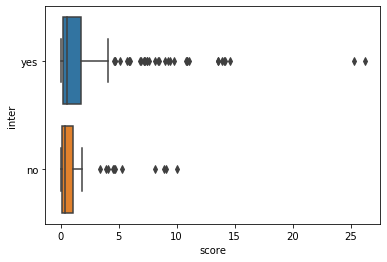

In [73]:
inter = set(kegg_path['pathways']) & set(kegg.index)
kegg_path['inter'] = 'no'
kegg_path.loc[kegg_path['pathways'].isin(inter), 'inter'] = 'yes'
ax = sns.boxplot(data=kegg_path, x='score', y='inter')
ax.figure.savefig('../kegg/krona/pathways_intersec_with_eggnog.png')

In [70]:
# eggnog functional categories
func_cat_sum = model.groupby('COGFunctionalCategory').sum().sort_values('score', ascending=False)
func_cat_sum.rename(columns={'score':'score_sum'}, inplace=True)
func_cat_mean = model.groupby('COGFunctionalCategory').mean().sort_values('score', ascending=False)
func_cat_mean.rename(columns={'score':'score_mean'}, inplace=True)
func_cat_mean.drop('ProteinCount', inplace=True, axis=1)
func_cat = func_cat_mean.merge(func_cat_sum, left_index=True, right_index=True).reset_index().sort_values('score_mean', ascending=False)

dd = {
'J' : 'Translation, ribosomal structure and biogenesis',
'A' : 'RNA processing and modification',
'K' : 'Transcription',
'L' : 'Replication, recombination and repair',
'B' : 'Chromatin structure and dynamics',
'D' : 'Cell cycle control, cell division, chromosome partitioning',
'Y' : 'Nuclear structure',
'V' : 'Defense mechanisms',
'T' : 'Signal transduction mechanisms',
'M' : 'Cell wall/membrane/envelope biogenesis',
'N' : 'Cell motility',
'Z' : 'Cytoskeleton',
'W' : 'Extracellular structures',
'U' : 'Intracellular trafficking, secretion, and vesicular transport',
'O' : 'Posttranslational modification, protein turnover, chaperones',
'C' : 'Energy production and conversion',
'G' : 'Carbohydrate transport and metabolism',
'E' : 'Amino acid transport and metabolism',
'F' : 'Nucleotide transport and metabolism',
'H' : 'Coenzyme transport and metabolism',
'I' : 'Lipid transport and metabolism',
'P' : 'Inorganic ion transport and metabolism',
'Q' : 'Secondary metabolites biosynthesis, transport and catabolism',
'R' : 'General function prediction only',
'S' : 'Function unknown'
}
func_cat['COGFunctionalCategory'] = func_cat['COGFunctionalCategory'].apply(lambda x: dd[x])
print(func_cat.sort_values('score_sum', ascending=False).to_markdown())

|    | COGFunctionalCategory                                         |   score_mean |   score_sum |   ProteinCount |
|---:|:--------------------------------------------------------------|-------------:|------------:|---------------:|
|  1 | Function unknown                                              |    0.0667317 | 4599.35     |        2209675 |
| 11 | Transcription                                                 |    0.0614815 |  317.982    |         485184 |
|  0 | Cell wall/membrane/envelope biogenesis                        |    0.0671169 |  234.506    |         391876 |
|  6 | Carbohydrate transport and metabolism                         |    0.0643051 |  218.316    |         490194 |
| 14 | Replication, recombination and repair                         |    0.0588104 |  209.777    |         474757 |
|  2 | Amino acid transport and metabolism                           |    0.0666461 |  208.002    |         681825 |
|  9 | Energy production and conversion                         

In [79]:
func_cat.to_csv('eggnog_func_cat_scores.tsv', sep='\t')

42